In [1]:
import tensorflow as tf  
import numpy as np
import os
import glob
import matplotlib.pyplot as plt 

gpus = tf.config.experimental.list_physical_devices(device_type='GPU') #本地需要这样操作
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu ,True)


In [2]:
x_train_path=glob.glob('./dataset/cityscapes/images/train/*/*.png')
print(x_train_path[:3],sep='\n')
print(len(x_train_path))


['./dataset/cityscapes/images/train\\aachen\\aachen_000000_000019_leftImg8bit.png', './dataset/cityscapes/images/train\\aachen\\aachen_000001_000019_leftImg8bit.png', './dataset/cityscapes/images/train\\aachen\\aachen_000002_000019_leftImg8bit.png']
2975


In [3]:
y_train_path=glob.glob('./dataset/cityscapes/gtFine/train/*/*_labelIds.png')
print(y_train_path[:3],sep='\n')
print(len(y_train_path))

['./dataset/cityscapes/gtFine/train\\aachen\\aachen_000000_000019_gtFine_labelIds.png', './dataset/cityscapes/gtFine/train\\aachen\\aachen_000001_000019_gtFine_labelIds.png', './dataset/cityscapes/gtFine/train\\aachen\\aachen_000002_000019_gtFine_labelIds.png']
2975


In [4]:
#乱序
np.random.seed(2020)
index=np.random.permutation(len(x_train_path))
x_train_path=np.array(x_train_path)[index]
y_train_path=np.array(y_train_path)[index]

In [5]:
#验证x y是否一致
print(x_train_path[500],y_train_path[500],sep='\n')


./dataset/cityscapes/images/train\zurich\zurich_000047_000019_leftImg8bit.png
./dataset/cityscapes/gtFine/train\zurich\zurich_000047_000019_gtFine_labelIds.png


In [6]:
#val数据五百张
x_val_path=glob.glob('./dataset/cityscapes/images/val/*/*.png')
y_val_path=glob.glob('./dataset/cityscapes/gtFine/val/*/*_labelIds.png')

In [7]:
#验证x y是否一致
print(x_val_path[12],y_val_path[12],sep='\n')


./dataset/cityscapes/images/val\frankfurt\frankfurt_000000_005898_leftImg8bit.png
./dataset/cityscapes/gtFine/val\frankfurt\frankfurt_000000_005898_gtFine_labelIds.png


In [8]:
train_path_dataset=tf.data.Dataset.from_tensor_slices((x_train_path,y_train_path))
val_path_dataset=tf.data.Dataset.from_tensor_slices((x_val_path,y_val_path))

In [9]:
print(train_path_dataset)
print(val_path_dataset)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>
<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.string)>


In [10]:
def read_png_x(path):
    img_raw=tf.io.read_file(path)
    img_tensor=tf.image.decode_png(img_raw,channels=3)
    return img_tensor 

def read_png_y(path):
    img_raw=tf.io.read_file(path)
    img_tensor=tf.image.decode_png(img_raw,channels=1)
    return img_tensor


In [11]:
#数据增强
#img_x  原图片
#img_y 分割图
def random_crop_img(img_x,img_y):
    concat_img=tf.concat([img_x,img_y],axis=-1)
    concat_img=tf.image.resize(concat_img,
                               (280,280),
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
                               )
    crop_img=tf.image.random_crop(concat_img,[256,256,4])
    return crop_img[:,:,:3],crop_img[:,:,3:] 

In [12]:
def normal(img_x,img_y):
    img_x=tf.cast(img_x,tf.float32)
    img_x=img_x/255
    img_y=tf.cast(img_y,tf.uint8)
    return img_x,img_y



In [13]:
def load_image_train(img_x_path,img_y_path):
    img_x=read_png_x(img_x_path)
    img_y=read_png_y(img_y_path)
    img_x,img_y=random_crop_img(img_x,img_y)
    if tf.random.uniform(())>0.5:
        img_x=tf.image.flip_left_right(img_x)
        img_y=tf.image.flip_left_right(img_y)
    img_x,img_y=normal(img_x,img_y)
    return img_x,img_y
def load_image_val(img_x_path,img_y_path):
    img_x=read_png_x(img_x_path)
    img_y=read_png_y(img_y_path)
    img_x=tf.image.resize(img_x,(256,256))
    img_y=tf.image.resize(img_y,(256,256))
    img_x,img_y=normal(img_x,img_y)
    return img_x,img_y

In [14]:
BATCH_SIZE=2
BUFFER_SIZE=300
TRAIN_COUNT=len(x_train_path)
VAL_COUNT=len(x_val_path)
auto=tf.data.experimental.AUTOTUNE



In [15]:
dataset_train=train_path_dataset.map(load_image_train,num_parallel_calls=auto)
dataset_val=val_path_dataset.map(load_image_val,num_parallel_calls=auto)

In [16]:
print(dataset_train)
print(dataset_val)

<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.uint8)>
<ParallelMapDataset shapes: ((256, 256, 3), (256, 256, 1)), types: (tf.float32, tf.uint8)>


In [17]:
dataset_train=dataset_train.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE).prefetch(auto)
dataset_val=dataset_val.repeat().batch(BATCH_SIZE)

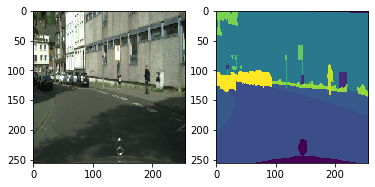

In [18]:
for img, musk in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow(img[0])
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze( musk[0]))

In [26]:
def creat_model():
    inputs=tf.keras.layers.Input(shape=(256,256,3))
    
    x=tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(inputs)
    #增加BN层 加快速度
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(x)
    x=tf.keras.layers.BatchNormalization()(x)    #256,256,64
    
    x1=tf.keras.layers.MaxPooling2D(padding='same')(x)    #128*128*64
    
    x1=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x1)
    x1=tf.keras.layers.BatchNormalization()(x1)
    x1=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x1)
    x1=tf.keras.layers.BatchNormalization()(x1)   #128*128*128
    
    x2=tf.keras.layers.MaxPooling2D(padding='same')(x1) #64*64*128
     
    x2=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x2)
    x2=tf.keras.layers.BatchNormalization()(x2)
    x2=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x2)
    x2=tf.keras.layers.BatchNormalization()(x2)   #64*64*256
    
    x3=tf.keras.layers.MaxPooling2D(padding='same')(x2) #32*32*256
    
    x3=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x3)
    x3=tf.keras.layers.BatchNormalization()(x3)
    x3=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x3)
    x3=tf.keras.layers.BatchNormalization()(x3)   #32*32*512
    
    x4=tf.keras.layers.MaxPooling2D(padding='same')(x3) #16*16*512
    
    x4=tf.keras.layers.Conv2D(1024,3,padding='same',activation='relu')(x4)
    x4=tf.keras.layers.BatchNormalization()(x4)
    x4=tf.keras.layers.Conv2D(1024,3,padding='same',activation='relu')(x4)
    x4=tf.keras.layers.BatchNormalization()(x4)   #16*16*1024
    
    #上采样部分
    
    x5=tf.keras.layers.Conv2DTranspose(512, 2,padding='same',strides=2,activation='relu')(x4)
    x5=tf.keras.layers.BatchNormalization()(x5)  #32*32*512
    
    x6=tf.concat([x3,x5],axis=-1)  #32*32*1024
    
    x6=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x6)
    x6=tf.keras.layers.BatchNormalization()(x6)
    x6=tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x6)
    x6=tf.keras.layers.BatchNormalization()(x6)   #32*32*512
    
    x7=tf.keras.layers.Conv2DTranspose(256, 2,padding='same',strides=2,activation='relu')(x6)
    x7=tf.keras.layers.BatchNormalization()(x7)  #64*64*256
    
    x8=tf.concat([x2,x7],axis=-1)  #64*64*512
    
    x8=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x8)
    x8=tf.keras.layers.BatchNormalization()(x8)
    x8=tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x8)
    x8=tf.keras.layers.BatchNormalization()(x8)   #64*64*256
    
    x9=tf.keras.layers.Conv2DTranspose(128, 2,padding='same',strides=2,activation='relu')(x8)
    x9=tf.keras.layers.BatchNormalization()(x9)  #128*128*128
    
    x10=tf.concat([x1,x9],axis=-1) #128*128*256
    
    x10=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x10)
    x10=tf.keras.layers.BatchNormalization()(x10)
    x10=tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x10)
    x10=tf.keras.layers.BatchNormalization()(x10)   #128*128*128
    
    x11=tf.keras.layers.Conv2DTranspose(64, 2,padding='same',strides=2,activation='relu')(x10)
    x11=tf.keras.layers.BatchNormalization()(x11)  #256*256*64
    
    x12=tf.concat([x,x11],axis=-1)  #256*256*128
    
    x12=tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(x12)
    x12=tf.keras.layers.BatchNormalization()(x12)
    x12=tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(x12)
    x12=tf.keras.layers.BatchNormalization()(x12)   #256*256*64
    
    output=tf.keras.layers.Conv2D(34,1,padding='same',activation='softmax')(x12)
                                                #256,256,8
    return tf.keras.Model(
        inputs=inputs,
        outputs=output
    )

In [27]:
model=creat_model()

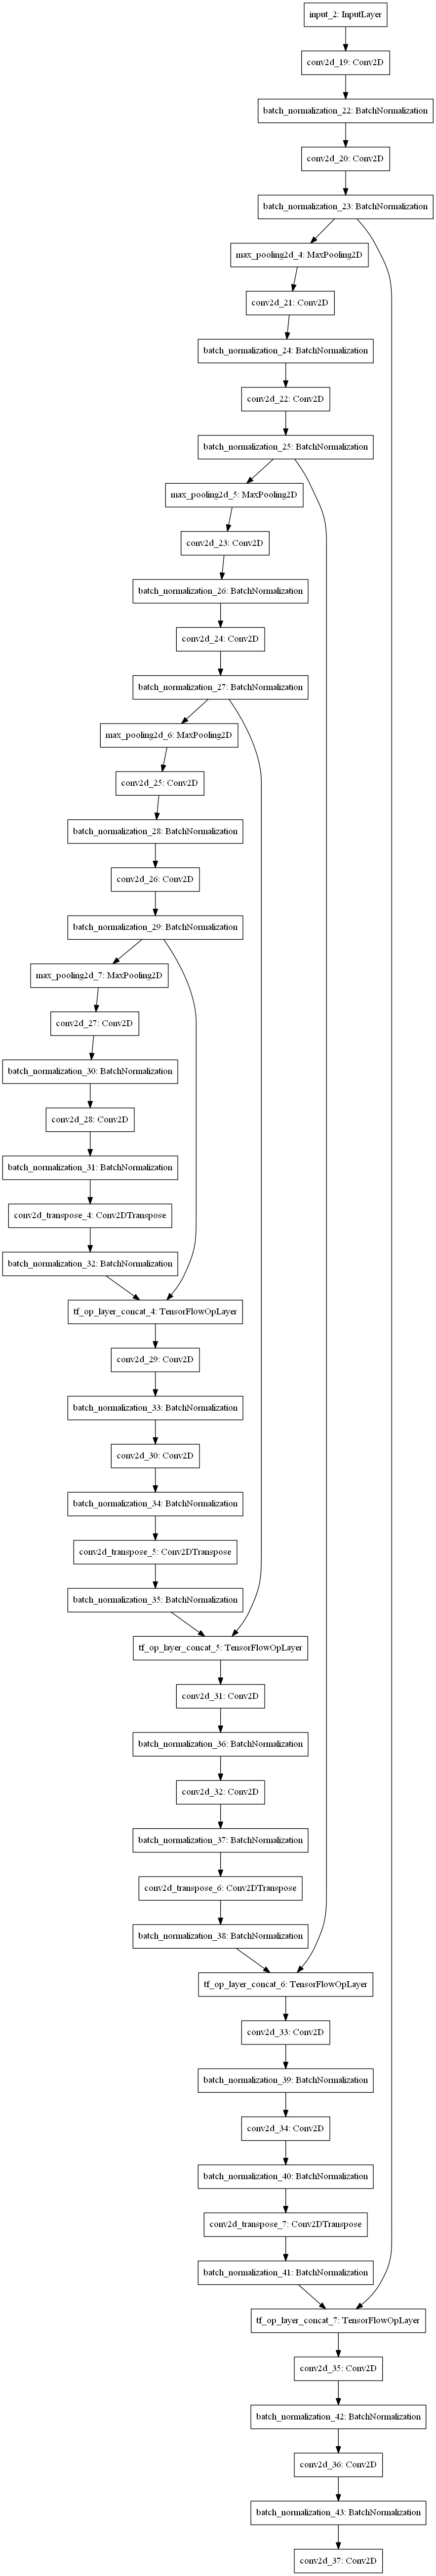

In [28]:
tf.keras.utils.plot_model(model,'model_unet.png')

In [29]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self,y_true,y_pred,sample_weight=None):
        y_pred=tf.argmax(y_pred,axis=-1)
        return super().__call__(y_true,y_pred,sample_weight=sample_weight)

In [30]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(0.001), 
        loss='sparse_categorical_crossentropy',
        metrics=['acc', MeanIoU(num_classes=34)])


In [31]:
his=model.fit(
    dataset_train,
    epochs=1,
    steps_per_epoch=TRAIN_COUNT//BATCH_SIZE,
    validation_data=dataset_val,
    validation_steps=VAL_COUNT//BATCH_SIZE
)


Train for 1487 steps, validate for 250 steps
1487/1487 [==============================] - 288s 194ms/step - loss: 1.0618 - acc: 0.7015 - mean_io_u_1: 0.1144 - val_loss: 3.2675 - val_acc: 0.4003 - val_mean_io_u_1: 0.0603

In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

(256, 256)


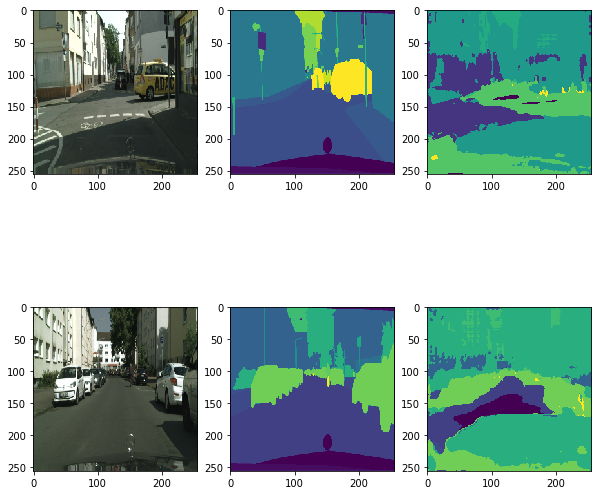

In [46]:
num=2
for image, mask in dataset_val.take(1):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    print(pred_mask[0].shape)
    # pred_mask = pred_mask[..., tf.newaxis]
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(image[i])
        plt.subplot(num, 3, i*3+2)
        plt.imshow(np.squeeze(mask[i]))
        plt.subplot(num, 3, i*3+3)
        plt.imshow(pred_mask[i])
